

# FOMC Statements Analysis




#Introduction
The recent surge in inflation has put central banks back into the spotlight. Our work proposes a novel method to analyze monetary policy using information in the language of documents that economists at the Federal Reserve Board prepare for Federal Open Market Committee (FOMC) meetings and try to make a short term (6 months) prediction in policy decision making by XGBoost and we ultimately achieved a prediction accuracy of 75%.


The US interest is predictable, for example the 2-Year Treasury Rate reflects market expectations about future interest rates, including the Federal Funds Rate. Investors and market participants closely monitor Treasury yields and adjust their expectations based on economic conditions, monetary policy outlook, and other factors.



Also, the analysts can directly interpret the statement, for example after the meeting on January 30th 2024, they [give an opinion](https://www.bloomberg.com/news/articles/2024-01-31/jerome-powell-fed-to-hold-us-interest-rates-in-effort-to-fight-inflation) that The Federal Reserve will likely hold interest rates steady for a fourth straight meeting but avoid signaling an imminent interest-rate cut. Incorporating quantitative analysis with NLP enables us to derive more confident conclusions.



IN 2016, TWO SIGMA published a report on [applying a natural language processing algo to to quantify Fed discussions](https://www.twosigma.com/articles/an-ai-approach-to-fed-watching/). Then this approach has been becoming more and more popular. There are also some economists combine NLP and econometrics for analysis, such as [Identifying Monetary Policy Shocks: A Natural Language Approach
](https://econweb.umd.edu/~drechsel/papers/Aruoba_Drechsel.pdf), which got a $R^2$ of 0.94 by combinging NLP with regression. Also there are [works](https://arxiv.org/abs/2305.07972) directly study the policy impact on the treasury market, stock market, and macroeconomic indicators.

#Dataset Overview

In [1]:
## Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction import _stop_words
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem import SnowballStemmer
from xgboost import XGBClassifier, plot_importance
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

%load_ext autoreload
%autoreload 2
%matplotlib inline

from datetime import date
from pathlib import Path
import seaborn as sns

## Temporal Scope

As it is shown with a very high rate that 1980s-1990s was characterized by a focus on price stability and maintaining moderate inflation levels. Under Volcker and Greenspan, the Federal Reserve adopted a pragmatic approach to monetary policy, often adjusting interest rates in response to economic data and financial market conditions.

And we can see that in 2010s there was a period where FFR almost 0, which is a huge difference from before. So we decide to use the data since 1999, which might be more proper for recent analysis.

## Import Data and Data Modification
Our analysis is based on two pillars: text data (i.e. FOMC statements) and rates data. We got the data from [Federal Reserve Bank of St. Louis](https://fred.stlouisfed.org/series/FEDFUNDS#0) and [FOMC website](https://www.federalreserve.gov/monetarypolicy/fomccalendars.htm)

In [2]:
## Interest Rates

df_int= pd.read_csv('FEDFUNDS.csv')
df_int['DATE'] = pd.to_datetime(df_int['DATE'])
df_int.columns = ['date','rate']

In [3]:
## FOMC statements

df_texts = pd.read_csv("FOMC statements.csv")
df_texts = df_texts[['release_date',"text"]]
df_texts.columns = ['date','text']
df_texts['date'] = pd.to_datetime(df_texts['date'])
df_texts['date'] = df_texts['date'] + pd.offsets.MonthBegin(1)
df_texts = df_texts.groupby('date')['text'].agg(lambda x: ' '.join(x)).reset_index()

In [4]:
statements = df_texts.copy()

In [5]:
df_texts

,date,text
0,1999-06-01,The Federal Reserve released the following sta...
1,1999-07-01,The Federal Open Market Committee today voted ...
2,1999-09-01,With financial markets functioning more normal...
3,1999-11-01,The Federal Open Market Committee decided toda...
4,1999-12-01,Although cost pressures appear generally conta...
...,...,...
198,2023-08-01,Recent indicators suggest that economic activi...
199,2023-10-01,Recent indicators suggest that economic activi...
200,2023-12-01,Recent indicators suggest that economic activi...
201,2024-01-01,Recent indicators suggest that growth of econo...


## Data sources

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

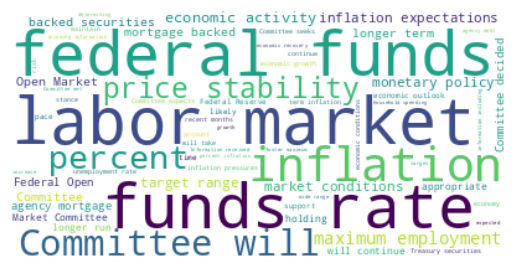

In [7]:
wctext = df_texts["text"].str.cat(sep=' ')
# Generate and plot WordCloud for full corpus
wordcloud = WordCloud(background_color="white").generate(wctext)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Sentiment Analysis

The Loughran-McDonald Master Dictionary is a specialized dictionary designed for sentiment analysis in financial contexts. Analyzing the sentiment of the FOMC statement can provide some insights. By leveraging the Loughran-McDonald, we can extract valuable information from the statement and incorporate sentiment analysis into the modelling in the following section.

In [8]:
statements.set_index('date', inplace= True)
statements.sort_index(inplace=True)

In [9]:
statements['Index'] = range(0, len(statements))

In [10]:
import re

lmdict = {'Negative': ['abandon', 'abandoned', 'abandoning', 'abandonment', 'abandonments', 'abandons', 'abdicated',
                       'abdicates', 'abdicating', 'abdication', 'abdications', 'aberrant', 'aberration', 'aberrational',
                       'aberrations', 'abetting', 'abnormal', 'abnormalities', 'abnormality', 'abnormally', 'abolish',
                       'abolished', 'abolishes', 'abolishing', 'abrogate', 'abrogated', 'abrogates', 'abrogating',
                       'abrogation', 'abrogations', 'abrupt', 'abruptly', 'abruptness', 'absence', 'absences',
                       'absenteeism', 'abuse', 'abused', 'abuses', 'abusing', 'abusive', 'abusively', 'abusiveness',
                       'accident', 'accidental', 'accidentally', 'accidents', 'accusation', 'accusations', 'accuse',
                       'accused', 'accuses', 'accusing', 'acquiesce', 'acquiesced', 'acquiesces', 'acquiescing',
                       'acquit', 'acquits', 'acquittal', 'acquittals', 'acquitted', 'acquitting', 'adulterate',
                       'adulterated', 'adulterating', 'adulteration', 'adulterations', 'adversarial', 'adversaries',
                       'adversary', 'adverse', 'adversely', 'adversities', 'adversity', 'aftermath', 'aftermaths',
                       'against', 'aggravate', 'aggravated', 'aggravates', 'aggravating', 'aggravation', 'aggravations',
                       'alerted', 'alerting', 'alienate', 'alienated', 'alienates', 'alienating', 'alienation',
                       'alienations', 'allegation', 'allegations', 'allege', 'alleged', 'allegedly', 'alleges',
                       'alleging', 'annoy', 'annoyance', 'annoyances', 'annoyed', 'annoying', 'annoys', 'annul',
                       'annulled', 'annulling', 'annulment', 'annulments', 'annuls', 'anomalies', 'anomalous',
                       'anomalously', 'anomaly', 'anticompetitive', 'antitrust', 'argue', 'argued', 'arguing',
                       'argument', 'argumentative', 'arguments', 'arrearage', 'arrearages', 'arrears', 'arrest',
                       'arrested', 'arrests', 'artificially', 'assault', 'assaulted', 'assaulting', 'assaults',
                       'assertions', 'attrition', 'aversely', 'backdating', 'bad', 'bail', 'bailout', 'balk', 'balked',
                       'bankrupt', 'bankruptcies', 'bankruptcy', 'bankrupted', 'bankrupting', 'bankrupts', 'bans',
                       'barred', 'barrier', 'barriers', 'bottleneck', 'bottlenecks', 'boycott', 'boycotted',
                       'boycotting', 'boycotts', 'breach', 'breached', 'breaches', 'breaching', 'break', 'breakage',
                       'breakages', 'breakdown', 'breakdowns', 'breaking', 'breaks', 'bribe', 'bribed', 'briberies',
                       'bribery', 'bribes', 'bribing', 'bridge', 'broken', 'burden', 'burdened', 'burdening', 'burdens',
                       'burdensome', 'burned', 'calamities', 'calamitous', 'calamity', 'cancel', 'canceled',
                       'canceling', 'cancellation', 'cancellations', 'cancelled', 'cancelling', 'cancels', 'careless',
                       'carelessly', 'carelessness', 'catastrophe', 'catastrophes', 'catastrophic', 'catastrophically',
                       'caution', 'cautionary', 'cautioned', 'cautioning', 'cautions', 'cease', 'ceased', 'ceases',
                       'ceasing', 'censure', 'censured', 'censures', 'censuring', 'challenge', 'challenged',
                       'challenges', 'challenging', 'chargeoffs', 'circumvent', 'circumvented', 'circumventing',
                       'circumvention', 'circumventions', 'circumvents', 'claiming', 'claims', 'clawback', 'closed',
                       'closeout', 'closeouts', 'closing', 'closings', 'closure', 'closures', 'coerce', 'coerced',
                       'coerces', 'coercing', 'coercion', 'coercive', 'collapse', 'collapsed', 'collapses',
                       'collapsing', 'collision', 'collisions', 'collude', 'colluded', 'colludes', 'colluding',
                       'collusion', 'collusions', 'collusive', 'complain', 'complained', 'complaining', 'complains',
                       'complaint', 'complaints', 'complicate', 'complicated', 'complicates', 'complicating',
                       'complication', 'complications', 'compulsion', 'concealed', 'concealing', 'concede', 'conceded',
                       'concedes', 'conceding', 'concern', 'concerned', 'concerns', 'conciliating', 'conciliation',
                       'conciliations', 'condemn', 'condemnation', 'condemnations', 'condemned', 'condemning',
                       'condemns', 'condone', 'condoned', 'confess', 'confessed', 'confesses', 'confessing',
                       'confession', 'confine', 'confined', 'confinement', 'confinements', 'confines', 'confining',
                       'confiscate', 'confiscated', 'confiscates', 'confiscating', 'confiscation', 'confiscations',
                       'conflict', 'conflicted', 'conflicting', 'conflicts', 'confront', 'confrontation',
                       'confrontational', 'confrontations', 'confronted', 'confronting', 'confronts', 'confuse',
                       'confused', 'confuses', 'confusing', 'confusingly', 'confusion', 'conspiracies', 'conspiracy',
                       'conspirator', 'conspiratorial', 'conspirators', 'conspire', 'conspired', 'conspires',
                       'conspiring', 'contempt', 'contend', 'contended', 'contending', 'contends', 'contention',
                       'contentions', 'contentious', 'contentiously', 'contested', 'contesting', 'contraction',
                       'contractions', 'contradict', 'contradicted', 'contradicting', 'contradiction', 'contradictions',
                       'contradictory', 'contradicts', 'contrary', 'controversial', 'controversies', 'controversy',
                       'convict', 'convicted', 'convicting', 'conviction', 'convictions', 'corrected', 'correcting',
                       'correction', 'corrections', 'corrects', 'corrupt', 'corrupted', 'corrupting', 'corruption',
                       'corruptions', 'corruptly', 'corruptness', 'costly', 'counterclaim', 'counterclaimed',
                       'counterclaiming', 'counterclaims', 'counterfeit', 'counterfeited', 'counterfeiter',
                       'counterfeiters', 'counterfeiting', 'counterfeits', 'countermeasure', 'countermeasures', 'crime',
                       'crimes', 'criminal', 'criminally', 'criminals', 'crises', 'crisis', 'critical', 'critically',
                       'criticism', 'criticisms', 'criticize', 'criticized', 'criticizes', 'criticizing', 'crucial',
                       'crucially', 'culpability', 'culpable', 'culpably', 'cumbersome', 'curtail', 'curtailed',
                       'curtailing', 'curtailment', 'curtailments', 'curtails', 'cut', 'cutback', 'cutbacks',
                       'cyberattack', 'cyberattacks', 'cyberbullying', 'cybercrime', 'cybercrimes', 'cybercriminal',
                       'cybercriminals', 'damage', 'damaged', 'damages', 'damaging', 'dampen', 'dampened', 'danger',
                       'dangerous', 'dangerously', 'dangers', 'deadlock', 'deadlocked', 'deadlocking', 'deadlocks',
                       'deadweight', 'deadweights', 'debarment', 'debarments', 'debarred', 'deceased', 'deceit',
                       'deceitful', 'deceitfulness', 'deceive', 'deceived', 'deceives', 'deceiving', 'deception',
                       'deceptions', 'deceptive', 'deceptively', 'decline', 'declined', 'declines', 'declining',
                       'deface', 'defaced', 'defacement', 'defamation', 'defamations', 'defamatory', 'defame',
                       'defamed', 'defames', 'defaming', 'default', 'defaulted', 'defaulting', 'defaults', 'defeat',
                       'defeated', 'defeating', 'defeats', 'defect', 'defective', 'defects', 'defend', 'defendant',
                       'defendants', 'defended', 'defending', 'defends', 'defensive', 'defer', 'deficiencies',
                       'deficiency', 'deficient', 'deficit', 'deficits', 'defraud', 'defrauded', 'defrauding',
                       'defrauds', 'defunct', 'degradation', 'degradations', 'degrade', 'degraded', 'degrades',
                       'degrading', 'delay', 'delayed', 'delaying', 'delays', 'deleterious', 'deliberate',
                       'deliberated', 'deliberately', 'delinquencies', 'delinquency', 'delinquent', 'delinquently',
                       'delinquents', 'delist', 'delisted', 'delisting', 'delists', 'demise', 'demised', 'demises',
                       'demising', 'demolish', 'demolished', 'demolishes', 'demolishing', 'demolition', 'demolitions',
                       'demote', 'demoted', 'demotes', 'demoting', 'demotion', 'demotions', 'denial', 'denials',
                       'denied', 'denies', 'denigrate', 'denigrated', 'denigrates', 'denigrating', 'denigration',
                       'deny', 'denying', 'deplete', 'depleted', 'depletes', 'depleting', 'depletion', 'depletions',
                       'deprecation', 'depress', 'depressed', 'depresses', 'depressing', 'deprivation', 'deprive',
                       'deprived', 'deprives', 'depriving', 'derelict', 'dereliction', 'derogatory', 'destabilization',
                       'destabilize', 'destabilized', 'destabilizing', 'destroy', 'destroyed', 'destroying', 'destroys',
                       'destruction', 'destructive', 'detain', 'detained', 'detention', 'detentions', 'deter',
                       'deteriorate', 'deteriorated', 'deteriorates', 'deteriorating', 'deterioration',
                       'deteriorations', 'deterred', 'deterrence', 'deterrences', 'deterrent', 'deterrents',
                       'deterring', 'deters', 'detract', 'detracted', 'detracting', 'detriment', 'detrimental',
                       'detrimentally', 'detriments', 'devalue', 'devalued', 'devalues', 'devaluing', 'devastate',
                       'devastated', 'devastating', 'devastation', 'deviate', 'deviated', 'deviates', 'deviating',
                       'deviation', 'deviations', 'devolve', 'devolved', 'devolves', 'devolving', 'difficult',
                       'difficulties', 'difficultly', 'difficulty', 'diminish', 'diminished', 'diminishes',
                       'diminishing', 'diminution', 'disadvantage', 'disadvantaged', 'disadvantageous', 'disadvantages',
                       'disaffiliation', 'disagree', 'disagreeable', 'disagreed', 'disagreeing', 'disagreement',
                       'disagreements', 'disagrees', 'disallow', 'disallowance', 'disallowances', 'disallowed',
                       'disallowing', 'disallows', 'disappear', 'disappearance', 'disappearances', 'disappeared',
                       'disappearing', 'disappears', 'disappoint', 'disappointed', 'disappointing', 'disappointingly',
                       'disappointment', 'disappointments', 'disappoints', 'disapproval', 'disapprovals', 'disapprove',
                       'disapproved', 'disapproves', 'disapproving', 'disassociates', 'disassociating',
                       'disassociation', 'disassociations', 'disaster', 'disasters', 'disastrous', 'disastrously',
                       'disavow', 'disavowal', 'disavowed', 'disavowing', 'disavows', 'disciplinary', 'disclaim',
                       'disclaimed', 'disclaimer', 'disclaimers', 'disclaiming', 'disclaims', 'disclose', 'disclosed',
                       'discloses', 'disclosing', 'discontinuance', 'discontinuances', 'discontinuation',
                       'discontinuations', 'discontinue', 'discontinued', 'discontinues', 'discontinuing', 'discourage',
                       'discouraged', 'discourages', 'discouraging', 'discredit', 'discredited', 'discrediting',
                       'discredits', 'discrepancies', 'discrepancy', 'disfavor', 'disfavored', 'disfavoring',
                       'disfavors', 'disgorge', 'disgorged', 'disgorgement', 'disgorgements', 'disgorges', 'disgorging',
                       'disgrace', 'disgraceful', 'disgracefully', 'dishonest', 'dishonestly', 'dishonesty', 'dishonor',
                       'dishonorable', 'dishonorably', 'dishonored', 'dishonoring', 'dishonors', 'disincentives',
                       'disinterested', 'disinterestedly', 'disinterestedness', 'disloyal', 'disloyally', 'disloyalty',
                       'dismal', 'dismally', 'dismiss', 'dismissal', 'dismissals', 'dismissed', 'dismisses',
                       'dismissing', 'disorderly', 'disparage', 'disparaged', 'disparagement', 'disparagements',
                       'disparages', 'disparaging', 'disparagingly', 'disparities', 'disparity', 'displace',
                       'displaced', 'displacement', 'displacements', 'displaces', 'displacing', 'dispose', 'dispossess',
                       'dispossessed', 'dispossesses', 'dispossessing', 'disproportion', 'disproportional',
                       'disproportionate', 'disproportionately', 'dispute', 'disputed', 'disputes', 'disputing',
                       'disqualification', 'disqualifications', 'disqualified', 'disqualifies', 'disqualify',
                       'disqualifying', 'disregard', 'disregarded', 'disregarding', 'disregards', 'disreputable',
                       'disrepute', 'disrupt', 'disrupted', 'disrupting', 'disruption', 'disruptions', 'disruptive',
                       'disrupts', 'dissatisfaction', 'dissatisfied', 'dissent', 'dissented', 'dissenter', 'dissenters',
                       'dissenting', 'dissents', 'dissident', 'dissidents', 'dissolution', 'dissolutions', 'distort',
                       'distorted', 'distorting', 'distortion', 'distortions', 'distorts', 'distract', 'distracted',
                       'distracting', 'distraction', 'distractions', 'distracts', 'distress', 'distressed', 'disturb',
                       'disturbance', 'disturbances', 'disturbed', 'disturbing', 'disturbs', 'diversion', 'divert',
                       'diverted', 'diverting', 'diverts', 'divest', 'divested', 'divesting', 'divestiture',
                       'divestitures', 'divestment', 'divestments', 'divests', 'divorce', 'divorced', 'divulge',
                       'divulged', 'divulges', 'divulging', 'doubt', 'doubted', 'doubtful', 'doubts', 'downgrade',
                       'downgraded', 'downgrades', 'downgrading', 'downsize', 'downsized', 'downsizes', 'downsizing',
                       'downsizings', 'downtime', 'downtimes', 'downturn', 'downturns', 'downward', 'downwards', 'drag',
                       'drastic', 'drastically', 'drawback', 'drawbacks', 'drop', 'dropped', 'drought', 'droughts', 'duress',
                       'dysfunction', 'dysfunctional', 'dysfunctions', 'easing', 'egregious', 'egregiously', 'embargo',
                       'embargoed', 'embargoes', 'embargoing', 'embarrass', 'embarrassed', 'embarrasses',
                       'embarrassing', 'embarrassment', 'embarrassments', 'embezzle', 'embezzled', 'embezzlement',
                       'embezzlements', 'embezzler', 'embezzles', 'embezzling', 'encroach', 'encroached', 'encroaches',
                       'encroaching', 'encroachment', 'encroachments', 'encumber', 'encumbered', 'encumbering',
                       'encumbers', 'encumbrance', 'encumbrances', 'endanger', 'endangered', 'endangering',
                       'endangerment', 'endangers', 'enjoin', 'enjoined', 'enjoining', 'enjoins', 'erode', 'eroded',
                       'erodes', 'eroding', 'erosion', 'erratic', 'erratically', 'erred', 'erring', 'erroneous',
                       'erroneously', 'error', 'errors', 'errs', 'escalate', 'escalated', 'escalates', 'escalating',
                       'evade', 'evaded', 'evades', 'evading', 'evasion', 'evasions', 'evasive', 'evict', 'evicted',
                       'evicting', 'eviction', 'evictions', 'evicts', 'exacerbate', 'exacerbated', 'exacerbates',
                       'exacerbating', 'exacerbation', 'exacerbations', 'exaggerate', 'exaggerated', 'exaggerates',
                       'exaggerating', 'exaggeration', 'excessive', 'excessively', 'exculpate', 'exculpated',
                       'exculpates', 'exculpating', 'exculpation', 'exculpations', 'exculpatory', 'exonerate',
                       'exonerated', 'exonerates', 'exonerating', 'exoneration', 'exonerations', 'exploit',
                       'exploitation', 'exploitations', 'exploitative', 'exploited', 'exploiting', 'exploits', 'expose',
                       'exposed', 'exposes', 'exposing', 'expropriate', 'expropriated', 'expropriates', 'expropriating',
                       'expropriation', 'expropriations', 'expulsion', 'expulsions', 'extenuating', 'fail', 'failed',
                       'failing', 'failings', 'fails', 'failure', 'failures', 'fallout', 'false', 'falsely',
                       'falsification', 'falsifications', 'falsified', 'falsifies', 'falsify', 'falsifying', 'falsity',
                       'fatalities', 'fatality', 'fatally', 'fault', 'faulted', 'faults', 'faulty', 'fear', 'fears',
                       'felonies', 'felonious', 'felony', 'fictitious', 'fined', 'fines', 'fired', 'firing', 'flaw',
                       'flawed', 'flaws', 'forbid', 'forbidden', 'forbidding', 'forbids', 'force', 'forced', 'forcing',
                       'foreclose', 'foreclosed', 'forecloses', 'foreclosing', 'foreclosure', 'foreclosures', 'forego',
                       'foregoes', 'foregone', 'forestall', 'forestalled', 'forestalling', 'forestalls', 'forfeit',
                       'forfeited', 'forfeiting', 'forfeits', 'forfeiture', 'forfeitures', 'forgers', 'forgery',
                       'fraud', 'frauds', 'fraudulence', 'fraudulent', 'fraudulently', 'frivolous', 'frivolously',
                       'frustrate', 'frustrated', 'frustrates', 'frustrating', 'frustratingly', 'frustration',
                       'frustrations', 'fugitive', 'fugitives', 'gratuitous', 'gratuitously', 'grievance', 'grievances',
                       'grossly', 'groundless', 'guilty', 'halt', 'halted', 'hamper', 'hampered', 'hampering',
                       'hampers', 'harass', 'harassed', 'harassing', 'harassment', 'hardship', 'hardships', 'harm',
                       'harmed', 'harmful', 'harmfully', 'harming', 'harms', 'harsh', 'harsher', 'harshest', 'harshly',
                       'harshness', 'hazard', 'hazardous', 'hazards', 'hinder', 'hindered', 'hindering', 'hinders',
                       'hindrance', 'hindrances', 'hostile', 'hostility', 'hurt', 'hurting', 'idle', 'idled', 'idling',
                       'ignore', 'ignored', 'ignores', 'ignoring', 'ill', 'illegal', 'illegalities', 'illegality',
                       'illegally', 'illegible', 'illicit', 'illicitly', 'illiquid', 'illiquidity', 'imbalance',
                       'imbalances', 'immature', 'immoral', 'impair', 'impaired', 'impairing', 'impairment',
                       'impairments', 'impairs', 'impasse', 'impasses', 'impede', 'impeded', 'impedes', 'impediment',
                       'impediments', 'impeding', 'impending', 'imperative', 'imperfection', 'imperfections', 'imperil',
                       'impermissible', 'implicate', 'implicated', 'implicates', 'implicating', 'impossibility',
                       'impossible', 'impound', 'impounded', 'impounding', 'impounds', 'impracticable', 'impractical',
                       'impracticalities', 'impracticality', 'imprisonment', 'improper', 'improperly', 'improprieties',
                       'impropriety', 'imprudent', 'imprudently', 'inability', 'inaccessible', 'inaccuracies',
                       'inaccuracy', 'inaccurate', 'inaccurately', 'inaction', 'inactions', 'inactivate', 'inactivated',
                       'inactivates', 'inactivating', 'inactivation', 'inactivations', 'inactivity', 'inadequacies',
                       'inadequacy', 'inadequate', 'inadequately', 'inadvertent', 'inadvertently', 'inadvisability',
                       'inadvisable', 'inappropriate', 'inappropriately', 'inattention', 'incapable', 'incapacitated',
                       'incapacity', 'incarcerate', 'incarcerated', 'incarcerates', 'incarcerating', 'incarceration',
                       'incarcerations', 'incidence', 'incidences', 'incident', 'incidents', 'incompatibilities',
                       'incompatibility', 'incompatible', 'incompetence', 'incompetency', 'incompetent',
                       'incompetently', 'incompetents', 'incomplete', 'incompletely', 'incompleteness', 'inconclusive',
                       'inconsistencies', 'inconsistency', 'inconsistent', 'inconsistently', 'inconvenience',
                       'inconveniences', 'inconvenient', 'incorrect', 'incorrectly', 'incorrectness', 'indecency',
                       'indecent', 'indefeasible', 'indefeasibly', 'indict', 'indictable', 'indicted', 'indicting',
                       'indictment', 'indictments', 'ineffective', 'ineffectively', 'ineffectiveness', 'inefficiencies',
                       'inefficiency', 'inefficient', 'inefficiently', 'ineligibility', 'ineligible', 'inequitable',
                       'inequitably', 'inequities', 'inequity', 'inevitable', 'inexperience', 'inexperienced',
                       'inferior', 'inflicted', 'infraction', 'infractions', 'infringe', 'infringed', 'infringement',
                       'infringements', 'infringes', 'infringing', 'inhibited', 'inimical', 'injunction', 'injunctions',
                       'injure', 'injured', 'injures', 'injuries', 'injuring', 'injurious', 'injury', 'inordinate',
                       'inordinately', 'inquiry', 'insecure', 'insensitive', 'insolvencies', 'insolvency', 'insolvent',
                       'instability', 'insubordination', 'insufficiency', 'insufficient', 'insufficiently',
                       'insurrection', 'insurrections', 'intentional', 'interfere', 'interfered', 'interference',
                       'interferences', 'interferes', 'interfering', 'intermittent', 'intermittently', 'interrupt',
                       'interrupted', 'interrupting', 'interruption', 'interruptions', 'interrupts', 'intimidation',
                       'intrusion', 'invalid', 'invalidate', 'invalidated', 'invalidates', 'invalidating',
                       'invalidation', 'invalidity', 'investigate', 'investigated', 'investigates', 'investigating',
                       'investigation', 'investigations', 'involuntarily', 'involuntary', 'irreconcilable',
                       'irreconcilably', 'irrecoverable', 'irrecoverably', 'irregular', 'irregularities',
                       'irregularity', 'irregularly', 'irreparable', 'irreparably', 'irreversible', 'jeopardize',
                       'jeopardized', 'justifiable', 'kickback', 'kickbacks', 'knowingly', 'lack', 'lacked', 'lacking',
                       'lackluster', 'lacks', 'lag', 'lagged', 'lagging', 'lags', 'lapse', 'lapsed', 'lapses',
                       'lapsing', 'late', 'laundering', 'layoff', 'layoffs', 'lie', 'limitation', 'limitations',
                       'lingering', 'liquidate', 'liquidated', 'liquidates', 'liquidating', 'liquidation',
                       'liquidations', 'liquidator', 'liquidators', 'litigant', 'litigants', 'litigate', 'litigated',
                       'litigates', 'litigating', 'litigation', 'litigations', 'lockout', 'lockouts', 'lose', 'loses',
                       'losing', 'loss', 'losses', 'lost', 'lying', 'malfeasance', 'malfunction', 'malfunctioned',
                       'malfunctioning', 'malfunctions', 'malice', 'malicious', 'maliciously', 'malpractice',
                       'manipulate', 'manipulated', 'manipulates', 'manipulating', 'manipulation', 'manipulations',
                       'manipulative', 'markdown', 'markdowns', 'misapplication', 'misapplications', 'misapplied',
                       'misapplies', 'misapply', 'misapplying', 'misappropriate', 'misappropriated', 'misappropriates',
                       'misappropriating', 'misappropriation', 'misappropriations', 'misbranded', 'miscalculate',
                       'miscalculated', 'miscalculates', 'miscalculating', 'miscalculation', 'miscalculations',
                       'mischaracterization', 'mischief', 'misclassification', 'misclassifications', 'misclassified',
                       'misclassify', 'miscommunication', 'misconduct', 'misdated', 'misdemeanor', 'misdemeanors',
                       'misdirected', 'mishandle', 'mishandled', 'mishandles', 'mishandling', 'misinform',
                       'misinformation', 'misinformed', 'misinforming', 'misinforms', 'misinterpret',
                       'misinterpretation', 'misinterpretations', 'misinterpreted', 'misinterpreting', 'misinterprets',
                       'misjudge', 'misjudged', 'misjudges', 'misjudging', 'misjudgment', 'misjudgments', 'mislabel',
                       'mislabeled', 'mislabeling', 'mislabelled', 'mislabels', 'mislead', 'misleading', 'misleadingly',
                       'misleads', 'misled', 'mismanage', 'mismanaged', 'mismanagement', 'mismanages', 'mismanaging',
                       'mismatch', 'mismatched', 'mismatches', 'mismatching', 'misplaced', 'misprice', 'mispricing',
                       'mispricings', 'misrepresent', 'misrepresentation', 'misrepresentations', 'misrepresented',
                       'misrepresenting', 'misrepresents', 'miss', 'missed', 'misses', 'misstate', 'misstated',
                       'misstatement', 'misstatements', 'misstates', 'misstating', 'misstep', 'missteps', 'mistake',
                       'mistaken', 'mistakenly', 'mistakes', 'mistaking', 'mistrial', 'mistrials', 'misunderstand',
                       'misunderstanding', 'misunderstandings', 'misunderstood', 'misuse', 'misused', 'misuses',
                       'misusing', 'monopolistic', 'monopolists', 'monopolization', 'monopolize', 'monopolized',
                       'monopolizes', 'monopolizing', 'monopoly', 'moratoria', 'moratorium', 'moratoriums',
                       'mothballed', 'mothballing', 'negative', 'negatively', 'negatives', 'neglect', 'neglected',
                       'neglectful', 'neglecting', 'neglects', 'negligence', 'negligences', 'negligent', 'negligently',
                       'nonattainment', 'noncompetitive', 'noncompliance', 'noncompliances', 'noncompliant',
                       'noncomplying', 'nonconforming', 'nonconformities', 'nonconformity', 'nondisclosure',
                       'nonfunctional', 'nonpayment', 'nonpayments', 'nonperformance', 'nonperformances',
                       'nonperforming', 'nonproducing', 'nonproductive', 'nonrecoverable', 'nonrenewal', 'nuisance',
                       'nuisances', 'nullification', 'nullifications', 'nullified', 'nullifies', 'nullify',
                       'nullifying', 'objected', 'objecting', 'objection', 'objectionable', 'objectionably',
                       'objections', 'obscene', 'obscenity', 'obsolescence', 'obsolete', 'obstacle', 'obstacles',
                       'obstruct', 'obstructed', 'obstructing', 'obstruction', 'obstructions', 'offence', 'offences',
                       'offend', 'offended', 'offender', 'offenders', 'offending', 'offends', 'omission', 'omissions',
                       'omit', 'omits', 'omitted', 'omitting', 'onerous', 'opportunistic', 'opportunistically',
                       'oppose', 'opposed', 'opposes', 'opposing', 'opposition', 'oppositions', 'outage', 'outages',
                       'outdated', 'outmoded', 'overage', 'overages', 'overbuild', 'overbuilding', 'overbuilds',
                       'overbuilt', 'overburden', 'overburdened', 'overburdening', 'overcapacities', 'overcapacity',
                       'overcharge', 'overcharged', 'overcharges', 'overcharging', 'overcome', 'overcomes',
                       'overcoming', 'overdue', 'overestimate', 'overestimated', 'overestimates', 'overestimating',
                       'overestimation', 'overestimations', 'overload', 'overloaded', 'overloading', 'overloads',
                       'overlook', 'overlooked', 'overlooking', 'overlooks', 'overpaid', 'overpayment', 'overpayments',
                       'overproduced', 'overproduces', 'overproducing', 'overproduction', 'overrun', 'overrunning',
                       'overruns', 'overshadow', 'overshadowed', 'overshadowing', 'overshadows', 'overstate',
                       'overstated', 'overstatement', 'overstatements', 'overstates', 'overstating', 'oversupplied',
                       'oversupplies', 'oversupply', 'oversupplying', 'overtly', 'overturn', 'overturned',
                       'overturning', 'overturns', 'overvalue', 'overvalued', 'overvaluing', 'panic', 'panics',
                       'penalize', 'penalized', 'penalizes', 'penalizing', 'penalties', 'penalty', 'peril', 'perils',
                       'perjury', 'perpetrate', 'perpetrated', 'perpetrates', 'perpetrating', 'perpetration', 'persist',
                       'persisted', 'persistence', 'persistent', 'persistently', 'persisting', 'persists', 'pervasive',
                       'pervasively', 'pervasiveness', 'petty', 'picket', 'picketed', 'picketing', 'plaintiff',
                       'plaintiffs', 'plea', 'plead', 'pleaded', 'pleading', 'pleadings', 'pleads', 'pleas', 'pled',
                       'poor', 'poorly', 'poses', 'posing', 'postpone', 'postponed', 'postponement', 'postponements',
                       'postpones', 'postponing', 'precipitated', 'precipitous', 'precipitously', 'preclude',
                       'precluded', 'precludes', 'precluding', 'predatory', 'prejudice', 'prejudiced', 'prejudices',
                       'prejudicial', 'prejudicing', 'premature', 'prematurely', 'pressing', 'pretrial', 'preventing',
                       'prevention', 'prevents', 'problem', 'problematic', 'problematical', 'problems', 'prolong',
                       'prolongation', 'prolongations', 'prolonged', 'prolonging', 'prolongs', 'prone', 'prosecute',
                       'prosecuted', 'prosecutes', 'prosecuting', 'prosecution', 'prosecutions', 'protest', 'protested',
                       'protester', 'protesters', 'protesting', 'protestor', 'protestors', 'protests', 'protracted',
                       'protraction', 'provoke', 'provoked', 'provokes', 'provoking', 'punished', 'punishes',
                       'punishing', 'punishment', 'punishments', 'punitive', 'purport', 'purported', 'purportedly',
                       'purporting', 'purports', 'question', 'questionable', 'questionably', 'questioned',
                       'questioning', 'questions', 'quit', 'quitting', 'racketeer', 'racketeering', 'rationalization',
                       'rationalizations', 'rationalize', 'rationalized', 'rationalizes', 'rationalizing',
                       'reassessment', 'reassessments', 'reassign', 'reassigned', 'reassigning', 'reassignment',
                       'reassignments', 'reassigns', 'recall', 'recalled', 'recalling', 'recalls', 'recession',
                       'recessionary', 'recessions', 'reckless', 'recklessly', 'recklessness', 'redact', 'redacted',
                       'redacting', 'redaction', 'redactions', 'redefault', 'redefaulted', 'redefaults', 'redress',
                       'redressed', 'redresses', 'redressing', 'refusal', 'refusals', 'refuse', 'refused', 'refuses',
                       'refusing', 'reject', 'rejected', 'rejecting', 'rejection', 'rejections', 'rejects',
                       'relinquish', 'relinquished', 'relinquishes', 'relinquishing', 'relinquishment',
                       'relinquishments', 'reluctance', 'reluctant', 'renegotiate', 'renegotiated', 'renegotiates',
                       'renegotiating', 'renegotiation', 'renegotiations', 'renounce', 'renounced', 'renouncement',
                       'renouncements', 'renounces', 'renouncing', 'reparation', 'reparations', 'repossessed',
                       'repossesses', 'repossessing', 'repossession', 'repossessions', 'repudiate', 'repudiated',
                       'repudiates', 'repudiating', 'repudiation', 'repudiations', 'resign', 'resignation',
                       'resignations', 'resigned', 'resigning', 'resigns', 'restate', 'restated', 'restatement',
                       'restatements', 'restates', 'restating', 'restructure', 'restructured', 'restructures',
                       'restructuring', 'restructurings', 'retaliate', 'retaliated', 'retaliates', 'retaliating',
                       'retaliation', 'retaliations', 'retaliatory', 'retribution', 'retributions', 'revocation',
                       'revocations', 'revoke', 'revoked', 'revokes', 'revoking', 'ridicule', 'ridiculed', 'ridicules',
                       'ridiculing', 'riskier', 'riskiest', 'risky', 'sabotage', 'sacrifice', 'sacrificed',
                       'sacrifices', 'sacrificial', 'sacrificing', 'scandalous', 'scandals', 'scrutinize',
                       'scrutinized', 'scrutinizes', 'scrutinizing', 'scrutiny', 'secrecy', 'seize', 'seized', 'seizes',
                       'seizing', 'sentenced', 'sentencing', 'serious', 'seriously', 'seriousness', 'setback',
                       'setbacks', 'sever', 'severe', 'severed', 'severely', 'severities', 'severity', 'sharply',
                       'shocked', 'shortage', 'shortages', 'shortfall', 'shortfalls', 'shrinkage', 'shrinkages', 'shut',
                       'shutdown', 'shutdowns', 'shuts', 'shutting', 'slander', 'slandered', 'slanderous', 'slanders',
                       'slippage', 'slippages', 'slow', 'slowdown', 'slowdowns', 'slowed', 'slower', 'slowest',
                       'slowing', 'slowly', 'slowness', 'sluggish', 'sluggishly', 'sluggishness', 'solvencies',
                       'solvency', 'spam', 'spammers', 'spamming', 'staggering', 'stagnant', 'stagnate', 'stagnated',
                       'stagnates', 'stagnating', 'stagnation', 'standstill', 'standstills', 'stolen', 'stoppage',
                       'stoppages', 'stopped', 'stopping', 'stops', 'strain', 'strained', 'straining', 'strains',
                       'stress', 'stressed', 'stresses', 'stressful', 'stressing', 'stringent', 'strong', 'subjected',
                       'subjecting', 'subjection', 'subpoena', 'subpoenaed', 'subpoenas', 'substandard', 'sue', 'sued',
                       'sues', 'suffer', 'suffered', 'suffering', 'suffers', 'suing', 'summoned', 'summoning',
                       'summons', 'summonses', 'susceptibility', 'susceptible', 'suspect', 'suspected', 'suspects',
                       'suspend', 'suspended', 'suspending', 'suspends', 'suspension', 'suspensions', 'suspicion',
                       'suspicions', 'suspicious', 'suspiciously', 'taint', 'tainted', 'tainting', 'taints', 'tampered',
                       'tense', 'terminate', 'terminated', 'terminates', 'terminating', 'termination', 'terminations',
                       'testify', 'testifying', 'threat', 'threaten', 'threatened', 'threatening', 'threatens',
                       'threats', 'tightening', 'tolerate', 'tolerated', 'tolerates', 'tolerating', 'toleration',
                       'tortuous', 'tortuously', 'tragedies', 'tragedy', 'tragic', 'tragically', 'traumatic', 'trouble',
                       'troubled', 'troubles', 'turbulence', 'turmoil', 'unable', 'unacceptable', 'unacceptably',
                       'unaccounted', 'unannounced', 'unanticipated', 'unapproved', 'unattractive', 'unauthorized',
                       'unavailability', 'unavailable', 'unavoidable', 'unavoidably', 'unaware', 'uncollectable',
                       'uncollected', 'uncollectibility', 'uncollectible', 'uncollectibles', 'uncompetitive',
                       'uncompleted', 'unconscionable', 'unconscionably', 'uncontrollable', 'uncontrollably',
                       'uncontrolled', 'uncorrected', 'uncover', 'uncovered', 'uncovering', 'uncovers', 'undeliverable',
                       'undelivered', 'undercapitalized', 'undercut', 'undercuts', 'undercutting', 'underestimate',
                       'underestimated', 'underestimates', 'underestimating', 'underestimation', 'underfunded',
                       'underinsured', 'undermine', 'undermined', 'undermines', 'undermining', 'underpaid',
                       'underpayment', 'underpayments', 'underpays', 'underperform', 'underperformance',
                       'underperformed', 'underperforming', 'underperforms', 'underproduced', 'underproduction',
                       'underreporting', 'understate', 'understated', 'understatement', 'understatements',
                       'understates', 'understating', 'underutilization', 'underutilized', 'undesirable', 'undesired',
                       'undetected', 'undetermined', 'undisclosed', 'undocumented', 'undue', 'unduly', 'uneconomic',
                       'uneconomical', 'uneconomically', 'unemployed', 'unemployment', 'unethical', 'unethically',
                       'unexcused', 'unexpected', 'unexpectedly', 'unfair', 'unfairly', 'unfavorability', 'unfavorable',
                       'unfavorably', 'unfavourable', 'unfeasible', 'unfit', 'unfitness', 'unforeseeable', 'unforeseen',
                       'unforseen', 'unfortunate', 'unfortunately', 'unfounded', 'unfriendly', 'unfulfilled',
                       'unfunded', 'uninsured', 'unintended', 'unintentional', 'unintentionally', 'unjust',
                       'unjustifiable', 'unjustifiably', 'unjustified', 'unjustly', 'unknowing', 'unknowingly',
                       'unlawful', 'unlawfully', 'unlicensed', 'unliquidated', 'unmarketable', 'unmerchantable',
                       'unmeritorious', 'unnecessarily', 'unnecessary', 'unneeded', 'unobtainable', 'unoccupied',
                       'unpaid', 'unperformed', 'unplanned', 'unpopular', 'unpredictability', 'unpredictable',
                       'unpredictably', 'unpredicted', 'unproductive', 'unprofitability', 'unprofitable', 'unqualified',
                       'unrealistic', 'unreasonable', 'unreasonableness', 'unreasonably', 'unreceptive',
                       'unrecoverable', 'unrecovered', 'unreimbursed', 'unreliable', 'unremedied', 'unreported',
                       'unresolved', 'unrest', 'unsafe', 'unsalable', 'unsaleable', 'unsatisfactory', 'unsatisfied',
                       'unsavory', 'unscheduled', 'unsellable', 'unsold', 'unsound', 'unstabilized', 'unstable',
                       'unsubstantiated', 'unsuccessful', 'unsuccessfully', 'unsuitability', 'unsuitable', 'unsuitably',
                       'unsuited', 'unsure', 'unsuspected', 'unsuspecting', 'unsustainable', 'untenable', 'untimely',
                       'untrusted', 'untruth', 'untruthful', 'untruthfully', 'untruthfulness', 'untruths', 'unusable',
                       'unwanted', 'unwarranted', 'unwelcome', 'unwilling', 'unwillingness', 'upset', 'urgency',
                       'urgent', 'usurious', 'usurp', 'usurped', 'usurping', 'usurps', 'usury', 'vandalism', 'verdict',
                       'verdicts', 'vetoed', 'victims', 'violate', 'violated', 'violates', 'violating', 'violation',
                       'violations', 'violative', 'violator', 'violators', 'violence', 'violent', 'violently',
                       'vitiate', 'vitiated', 'vitiates', 'vitiating', 'vitiation', 'voided', 'voiding', 'volatile',
                       'volatility', 'vulnerabilities', 'vulnerability', 'vulnerable', 'vulnerably', 'warn', 'warned',
                       'warning', 'warnings', 'warns', 'wasted', 'wasteful', 'wasting', 'weak', 'weaken', 'weakened',
                       'weakening', 'weakens', 'weaker', 'weakest', 'weakly', 'weakness', 'weaknesses', 'willfully',
                       'worries', 'worry', 'worrying', 'worse', 'worsen', 'worsened', 'worsening', 'worsens', 'worst',
                       'worthless', 'writedown', 'writedowns', 'writeoff', 'writeoffs', 'wrong', 'wrongdoing',
                       'wrongdoings', 'wrongful', 'wrongfully', 'wrongly',
                       'negative', 'negatives', 'fail', 'fails', 'failing', 'failure', 'weak', 'weakness', 'weaknesses',
                       'difficult', 'difficulty', 'hurdle', 'hurdles', 'obstacle', 'obstacles', 'slump', 'slumps',
                       'slumping', 'slumped', 'uncertain', 'uncertainty', 'unsettled', 'unfavorable', 'downturn',
                       'depressed', 'disappoint', 'disappoints', 'disappointing', 'disappointed', 'disappointment',
                       'risk', 'risks', 'risky', 'threat', 'threats', 'penalty', 'penalties', 'down', 'decrease',
                       'decreases', 'decreasing', 'decreased', 'decline', 'declines', 'declining', 'declined', 'fall',
                       'falls', 'falling', 'fell', 'fallen', 'drop', 'drops', 'dropping', 'dropped', 'deteriorate',
                       'deteriorates', 'deteriorating', 'deteriorated', 'worsen', 'worsens', 'worsening', 'weaken',
                       'weakens', 'weakening', 'weakened', 'worse', 'worst', 'low', 'lower', 'lowest', 'less', 'least',
                       'smaller', 'smallest', 'shrink', 'shrinks', 'shrinking', 'shrunk', 'below', 'under', 'challenge',
                       'challenges', 'challenging', 'challenged'
                      ],
          'Positive': ['able', 'abundance', 'abundant', 'acclaimed', 'accomplish', 'accomplished', 'accomplishes',
                       'accomplishing', 'accomplishment', 'accomplishments', 'achieve', 'achieved', 'achievement',
                       'achievements', 'achieves', 'achieving', 'adequately', 'advancement', 'advancements', 'advances',
                       'advancing', 'advantage', 'advantaged', 'advantageous', 'advantageously', 'advantages',
                       'alliance', 'alliances', 'assure', 'assured', 'assures', 'assuring', 'attain', 'attained',
                       'attaining', 'attainment', 'attainments', 'attains', 'attractive', 'attractiveness', 'beautiful',
                       'beautifully', 'beneficial', 'beneficially', 'benefit', 'benefited', 'benefiting', 'benefitted',
                       'benefitting', 'best', 'better', 'bolstered', 'bolstering', 'bolsters', 'boom', 'booming',
                       'boost', 'boosted', 'breakthrough', 'breakthroughs', 'brilliant', 'charitable', 'collaborate',
                       'collaborated', 'collaborates', 'collaborating', 'collaboration', 'collaborations',
                       'collaborative', 'collaborator', 'collaborators', 'compliment', 'complimentary', 'complimented',
                       'complimenting', 'compliments', 'conclusive', 'conclusively', 'conducive', 'confident',
                       'constructive', 'constructively', 'courteous', 'creative', 'creatively', 'creativeness',
                       'creativity', 'delight', 'delighted', 'delightful', 'delightfully', 'delighting', 'delights',
                       'dependability', 'dependable', 'desirable', 'desired', 'despite', 'destined', 'diligent',
                       'diligently', 'distinction', 'distinctions', 'distinctive', 'distinctively', 'distinctiveness',
                       'dream', 'easier', 'easily', 'easy', 'effective', 'efficiencies', 'efficiency', 'efficient',
                       'efficiently', 'empower', 'empowered', 'empowering', 'empowers', 'enable', 'enabled', 'enables',
                       'enabling', 'encouraged', 'encouragement', 'encourages', 'encouraging', 'enhance', 'enhanced',
                       'enhancement', 'enhancements', 'enhances', 'enhancing', 'enjoy', 'enjoyable', 'enjoyably',
                       'enjoyed', 'enjoying', 'enjoyment', 'enjoys', 'enthusiasm', 'enthusiastic', 'enthusiastically',
                       'excellence', 'excellent', 'excelling', 'excels', 'exceptional', 'exceptionally', 'excited',
                       'excitement', 'exciting', 'exclusive', 'exclusively', 'exclusiveness', 'exclusives',
                       'exclusivity', 'exemplary', 'fantastic', 'favorable', 'favorably', 'favored', 'favoring',
                       'favorite', 'favorites', 'friendly', 'gain', 'gained', 'gaining', 'gains', 'good', 'great',
                       'greater', 'greatest', 'greatly', 'greatness', 'happiest', 'happily', 'happiness', 'happy',
                       'highest', 'honor', 'honorable', 'honored', 'honoring', 'honors', 'ideal', 'impress',
                       'impressed', 'impresses', 'impressing', 'impressive', 'impressively', 'improve', 'improved',
                       'improvement', 'improvements', 'improves', 'improving', 'incredible', 'incredibly',
                       'influential', 'informative', 'ingenuity', 'innovate', 'innovated', 'innovates', 'innovating',
                       'innovation', 'innovations', 'innovative', 'innovativeness', 'innovator', 'innovators',
                       'insightful', 'inspiration', 'inspirational', 'integrity', 'invent', 'invented', 'inventing',
                       'invention', 'inventions', 'inventive', 'inventiveness', 'inventor', 'inventors', 'leadership',
                       'leading', 'loyal', 'lucrative', 'meritorious', 'opportunities', 'opportunity', 'optimistic',
                       'outperform', 'outperformed', 'outperforming', 'outperforms', 'perfect', 'perfected',
                       'perfectly', 'perfects', 'pleasant', 'pleasantly', 'pleased', 'pleasure', 'plentiful', 'popular',
                       'popularity', 'positive', 'positively', 'preeminence', 'preeminent', 'premier', 'premiere',
                       'prestige', 'prestigious', 'proactive', 'proactively', 'proficiency', 'proficient',
                       'proficiently', 'profitability', 'profitable', 'profitably', 'progress', 'progressed',
                       'progresses', 'progressing', 'prospered', 'prospering', 'prosperity', 'prosperous', 'prospers',
                       'rebound', 'rebounded', 'rebounding', 'receptive', 'regain', 'regained', 'regaining', 'resolve',
                       'revolutionize', 'revolutionized', 'revolutionizes', 'revolutionizing', 'reward', 'rewarded',
                       'rewarding', 'rewards', 'satisfaction', 'satisfactorily', 'satisfactory', 'satisfied',
                       'satisfies', 'satisfy', 'satisfying', 'smooth', 'smoothing', 'smoothly', 'smooths', 'solves',
                       'solving', 'spectacular', 'spectacularly', 'stability', 'stabilization', 'stabilizations',
                       'stabilize', 'stabilized', 'stabilizes', 'stabilizing', 'stable', 'strength', 'strengthen',
                       'strengthened', 'strengthening', 'strengthens', 'strengths', 'strong', 'stronger', 'strongest',
                       'succeed', 'succeeded', 'succeeding', 'succeeds', 'success', 'successes', 'successful',
                       'successfully', 'superior', 'surpass', 'surpassed', 'surpasses', 'surpassing', "sustainable", 'transparency',
                       'tremendous', 'tremendously', 'unmatched', 'unparalleled', 'unsurpassed', 'upturn', 'upturns',
                       'valuable', 'versatile', 'versatility', 'vibrancy', 'vibrant', 'win', 'winner', 'winners', 'winning', 'worthy',
                       'positive', 'positives', 'success', 'successes', 'successful', 'succeed', 'succeeds',
                       'succeeding', 'succeeded', 'accomplish', 'accomplishes', 'accomplishing', 'accomplished',
                       'accomplishment', 'accomplishments', 'strong', 'strength', 'strengths', 'certain', 'certainty',
                       'definite', 'solid', 'excellent', 'good', 'leading', 'achieve', 'achieves', 'achieved',
                       'achieving', 'achievement', 'achievements', 'progress', 'progressing', 'deliver', 'delivers',
                       'delivered', 'delivering', 'leader', 'leading', 'pleased', 'reward', 'rewards', 'rewarding',
                       'rewarded', 'opportunity', 'opportunities', 'enjoy', 'enjoys', 'enjoying', 'enjoyed',
                       'encouraged', 'encouraging', 'up', 'increase', 'increases', 'increasing', 'increased', 'rise',
                       'rises', 'rising', 'rose', 'risen', 'improve', 'improves', 'improving', 'improved', 'improvement',
                       'improvements', 'strengthen', 'strengthens', 'strengthening', 'strengthened', 'stronger',
                       'strongest', 'better', 'best', 'more', 'most', 'above', 'record', 'high', 'higher', 'highest',
                       'greater', 'greatest', 'larger', 'largest', 'grow', 'grows', 'growing', 'grew', 'grown', 'growth',
                       'expand', 'expands', 'expanding', 'expanded', 'expansion', 'exceed', 'exceeds', 'exceeded',
                       'exceeding', 'beat', 'beats', 'beating']
         }

negate = ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt", "ain't", "aren't", "can't",
          "couldn't", "daren't", "didn't", "doesn't", "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt",
          "neither", "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't", "neednt", "needn't",
          "never", "none", "nope", "nor", "not", "nothing", "nowhere", "oughtnt", "shant", "shouldnt", "wasnt",
          "werent", "oughtn't", "shan't", "shouldn't", "wasn't", "weren't", "without", "wont", "wouldnt", "won't",
          "wouldn't", "rarely", "seldom", "despite", "no", "nobody"]

In [11]:
def negated(word):
    """
    Determine if preceding word is a negation word
    """
    if word.lower() in negate:
        return True
    else:
        return False

In [12]:
def tone_count_with_negation_check(dict, article):
    """
    Count positive and negative words with negation check. Account for simple negation only for positive words.
    Simple negation is taken to be observations of one of negate words occurring within three words
    preceding a positive words.
    """
    pos_count = 0
    neg_count = 0

    pos_words = []
    neg_words = []

    input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', article.lower())

    word_count = len(input_words)

    for i in range(0, word_count):
        if input_words[i] in dict['Negative']:
            neg_count += 1
            neg_words.append(input_words[i])
        if input_words[i] in dict['Positive']:
            if i >= 3:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]) or negated(input_words[i - 3]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 2:
                if negated(input_words[i - 1]) or negated(input_words[i - 2]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 1:
                if negated(input_words[i - 1]):
                    neg_count += 1
                    neg_words.append(input_words[i] + ' (with negation)')
                else:
                    pos_count += 1
                    pos_words.append(input_words[i])
            elif i == 0:
                pos_count += 1
                pos_words.append(input_words[i])

    results = [word_count, pos_count, neg_count, pos_words, neg_words]

    return results

In [13]:
temp = [tone_count_with_negation_check(lmdict,x) for x in statements.text]
temp = pd.DataFrame(temp)

statements['wordcount'] = temp.iloc[:,0].values
statements['NPositiveWords'] = temp.iloc[:,1].values
statements['NNegativeWords'] = temp.iloc[:,2].values
statements['Poswords'] = temp.iloc[:,3].values
statements['Negwords'] = temp.iloc[:,4].values

In [14]:
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

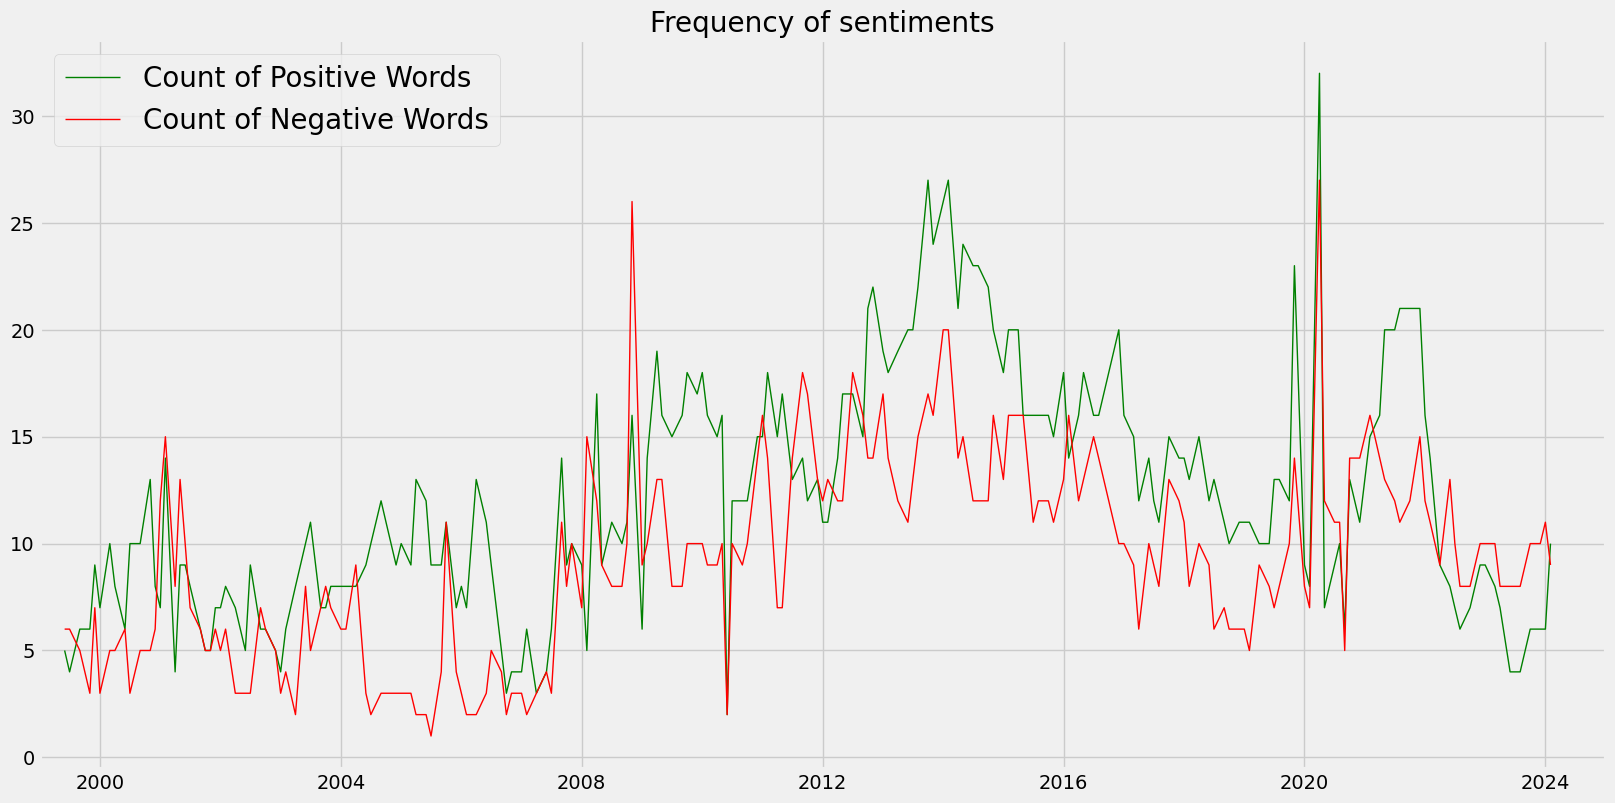

In [15]:
fig, ax = plt.subplots()

ax.plot(statements['NPositiveWords'],
         c = 'green',
         linewidth= 1.0)

plt.plot(statements['NNegativeWords'],
         c = 'red',
         linewidth=1.0)

plt.title('Frequency of sentiments')

plt.legend(['Count of Positive Words', 'Count of Negative Words'],
           prop={'size': 20},
           loc = 2
           )

# format the ticks
# round to nearest years.
import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

datemin = np.datetime64(statements.index[0], 'Y')
datemax = np.datetime64(statements.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)

plt.show()


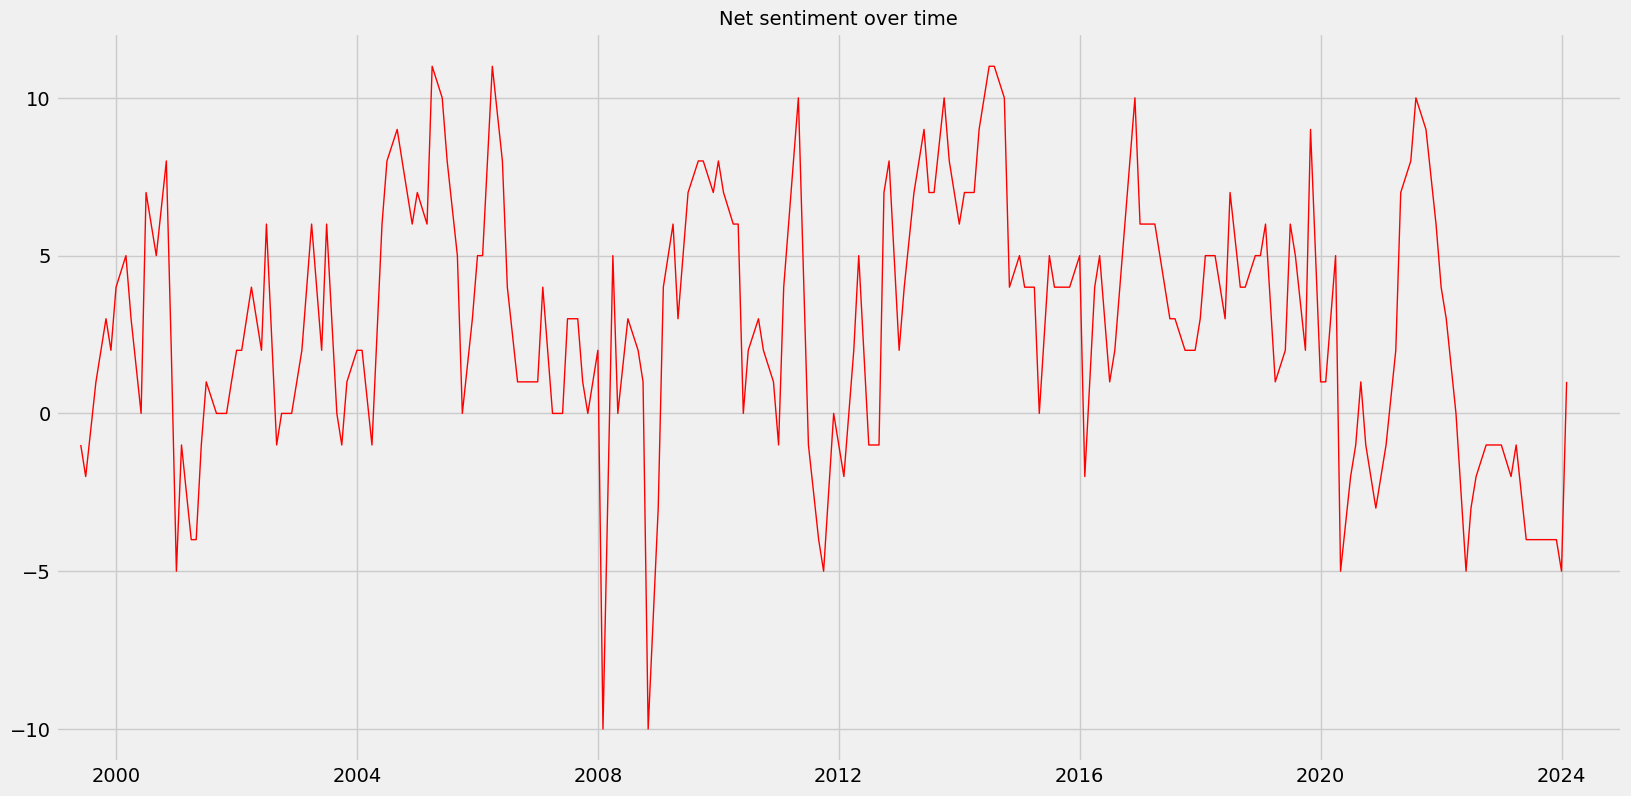

In [16]:
NetSentiment = (statements['NPositiveWords'] - statements['NNegativeWords'])

fig, ax = plt.subplots()

ax.plot(NetSentiment,
         c = 'red',
         linewidth= 1.0)

plt.title('Net sentiment over time',size = 'medium')

# format the ticks
# round to nearest years.
datemin = np.datetime64(statements.index[0], 'Y')
datemax = np.datetime64(statements.index[-1], 'Y') + np.timedelta64(1, 'Y')
ax.set_xlim(datemin, datemax)

# format the coords message box
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.grid(True)


plt.show()

As the figures shown the alignment between the sentiment expressed in the FOMC statement and subsequent monetary policy decisions during 2004-2007 and 2021 until now. FOMC statement conveys positive sentiment, it often includes optimistic views on economic growth, labor market conditions, inflation expectations, among other factors. This sentiment suggest that the Federal Reserve views the economic conditions favorably, potentially supporting further decisions to increase interest rates.

#Analytics and learning strategies

## NLP technique
For the text analysis pillar, we consider applying the TF-IDF algorithm (Term Frequency–Inverse Document Frequency), which is is a measure of importance of a word to a document in a collection or corpus, adjusted for the fact that some words appear more frequently in general, as we hoping to extract the sentiment implying the intention of interest rate targeting.

As the implementation of our analysis is by [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html), we focus on the computation inside.
- a term $t$ of a document $d$ in a document set

### TF (Term Frequency):

TF measures the frequency of a term in a document. It is calculated as the number of times a term appears in a document divided by the total number of terms in the document. Each document is represented by a vector where each component represents the TF of a term in the document.

$$TF(t,d) = \frac{Count(t,d)}{Total(t,d)}$$
- $Count(t,d)$ is the number of times term $t$ appears in document $d$.
- $Total(t,d)$ is the total number of terms in document $d$.

### IDF (Inverse Document Frequency):

IDF measures the importance of a term in a collection of documents. It is calculated as the logarithm of the total number of documents divided by the number of documents containing the term, plus one (to avoid division by zero).
IDF is used to downweight terms that occur frequently across documents and upweight terms that occur rarely but are potentially more informative.

$$IDF(t) = log\frac{n+1}{df(t)+1}+ 1 $$
-  $n$ is the total number of documents in the document set
- $df(t)$ is the document frequency of t
- the document frequency is the number of documents in the document set that contain the term t.

Finally we get the TF-IDF:

$$TF-IDF(t, d) = TF(t, d) * IDF(t)$$

## Classification technique：XGBoost

For the rates analysis, we convert our task into a classification task, i.e. to identify hawkish, dovish or neutral. As the [tree-based methods usually has a better performance on spase data](https://arxiv.org/abs/2207.08815), we decided to utilize XGBoost.

Here we briefly illustrate the principles of the algorithm by the works of [Chen and Guestrin](https://arxiv.org/abs/1603.02754)

For a given data set with $n$ examples and $m$ features
$\mathcal{D} = {(x_i, y_i)} (|\mathcal{D}| = n, x_i \in \mathbb{R}^m, y_i \in \mathbb{R})$ uses $K$ additive functions to predict the output.

$$\hat{y_i}=\phi(x_i)=\sum_{k=1}^{K} f_k(x_i), f_k \in \mathcal{F}$$

where $\mathcal{F} = {f(x) = w_{q(x)}}(q : \mathbb{R}^m \xrightarrow{} T, w \in \mathbb{R}^T)$ is the space of regression trees.

- $q$ represents the structure of each tree that maps an example to the corresponding leaf index.
- $T$ is the number of leaves in the tree.
- Each $f_k$ corresponds to an independent tree structure
$q$ and leaf weights $w$.

To learn the set of functions used in the model, we minimize the following *regularized* objective.

$$\mathcal{L}(\phi) = \sum_{i}^{} l(\hat{y_i},y_i)+\sum_{k}^{}\Omega(f_k)$$

where $\Omega(f) = \gamma T+\frac{1}{2}\lambda||w||^2$.
- $l$ is a differentiable convex loss function that measures the difference between the prediction $\hat{y_i}$ and the target $y_i$.
- $\Omega$ penalizes the complexity of the model.

The additional regularization term helps to smooth the final learnt weights to avoid over-fitting. Thus, the regularized objective will tend to select a model employing simple and predictive functions.

Normally it is impossible to enumerate all the possible
tree structures $q$ and find the optimal parameter, so XGBoost proposed method instead:
let $\hat{y_i}^{(t)}$ be the
prediction of the $i$-th instance at the $t$-th iteration, we will
need to add $f_t$ to minimize the following objective.

$$ \Tilde{\mathcal{L}}^{(t)} = \sum_{i}^{n} [g_i f_t(x_i)+\frac{1}{2}h_i {f_t}^2(x_i)]+
    \Omega(f_t)$$

- $g_i=\partial^2_{\hat{y}^{(t-1)}} l(y_i,\hat{y}^{(t-1)})$ and $h_i=\partial^2_{\hat{y}^{(t-1)}} l(y_i,\hat{y}^{(t-1)})$
are first and second order gradient statistics on the loss function.

Then finally find the optimal weight ${w^*_j}$ of leaf $j$ for a fixed structure $q(x)$, we can compute  by
$${w^*_j} = \frac{\sum_{i \in I_j}^{}g_i}{\sum_{i \in I_j}^{}h_i+\lambda}$$

# Empirical Analysis

In [17]:
## Convert to monthly data, combine to single dataframe

df_int.set_index(['date'], inplace=True)
df_texts.set_index(['date'], inplace=True)
df_texts.sort_index(inplace=True)
df_texts.index = df_texts.index + pd.offsets.MonthBegin(1)
df_int.index = df_int.index + pd.offsets.MonthBegin(1)
df_complete = df_texts.merge(df_int,left_index=True, right_index=True)

In [18]:
## Calculate 6 month change

df_temp = df_complete.copy()
df_temp['change_6'] = df_complete['rate'].diff(6)

In [19]:
## Shift the interest rate change records up
df_temp['change_6'] = df_temp['change_6'].shift(-6)

## Target Creation
Target value will not be the exact interest rate, it will be the following 6 month sentiment (hawkish, dovish, neutral).  Since the actual interest rate varies day to day by slight amounts, a threshold will be set that the 6 month change must exceed for it to be considered a change.  

In [20]:
y = df_temp[['change_6']]

# Drop the NAN columns
text = df_temp[:-6]
y = y[:-6]

y_threshold = 0.25

def map_to_class(value):
    if value > y_threshold:
        return 1
    elif -y_threshold <= value <= y_threshold:
        return 0
    else:
        return -1

y['change_6'] = y['change_6'].map(map_to_class)

In [21]:
text.shape

(195, 3)

In [22]:
y.shape

(195, 1)

In [23]:
## Check for class balance

y['change_6'].value_counts()

 0    83
 1    64
-1    48
Name: change_6, dtype: int64

In [24]:
y = y.fillna(1)

## Modelling
This will include preprocessing, model fitting, model accuracy testing.
1. Lower case
2. Stemming
3. TFIDF vectorizer
4. Modelling using XGBoost

Here we use train_test_split function in sklearn to split the dataset into training set and test set. We examine the robustness of the model by choosing different combinations of training set and test set.

In [25]:
## Lower case

text['text'] = [i.lower() for i in text['text']]

## Stemming

snow = SnowballStemmer('english',)
text['text'] = [snow.stem(i) for i in text['text']]

In [26]:
## Instantiate a TFIDF vectorizer

vect = TfidfVectorizer(
                        stop_words='english',
                       max_features = 500,
                       ngram_range=(1, 3),
                       token_pattern=r"\b[a-zA-Z]{3,}\b")

X_text = vect.fit_transform(text['text'])

# Create a DataFrame to examine
text_filtered = pd.DataFrame(X_text.toarray(), columns=vect.get_feature_names_out ())
text_tfidf = text_filtered.copy() # create backup of TFIDF text for later use
text_filtered.head()

,accommodation,accommodative,accommodative stance,accommodative stance monetary,account,account wide,account wide range,action,actions,activity,...,underlying,unemployment,unemployment rate,utilization,view,warrant,wide,wide range,wide range information,year
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.155147,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184420,0.000000,0.099893,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.262881,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.153291,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.140392,0.158319,0.076045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.111892


In [27]:
## XGBoost model fitting and testing

xgb_model = XGBClassifier(objective='multi:softmax',
                          max_depth=3,
                          num_classes=3)

train_scores = []
test_scores = []

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y["change_6"] = le.fit_transform(y["change_6"])

for x in range(10):
    X_train, X_test, y_train, y_test = train_test_split(text_tfidf, y,test_size=0.3)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    test_score = round(xgb_model.score(X_test, y_test),2)
    train_score = round(xgb_model.score(X_train, y_train),2)
    # print(f'{xgb_model.get_params}')
    print(f'Run {x}... train: {train_score}, test: {test_score}')
    train_scores.append(train_score)
    test_scores.append(test_score)

print(f'Train average: {np.mean(train_scores)}')
print(f'Test average: {np.mean(test_scores)}')

Run 0... train: 1.0, test: 0.83
Run 1... train: 1.0, test: 0.76
Run 2... train: 1.0, test: 0.9
Run 3... train: 1.0, test: 0.86
Run 4... train: 1.0, test: 0.8
Run 5... train: 1.0, test: 0.86
Run 6... train: 1.0, test: 0.78
Run 7... train: 1.0, test: 0.85
Run 8... train: 1.0, test: 0.86
Run 9... train: 1.0, test: 0.85
Train average: 1.0
Test average: 0.835


## Feature Importance
We calculated feature importance of different words and found that words such as "pressure", "growth", "committee" are contributing the most to the prediction

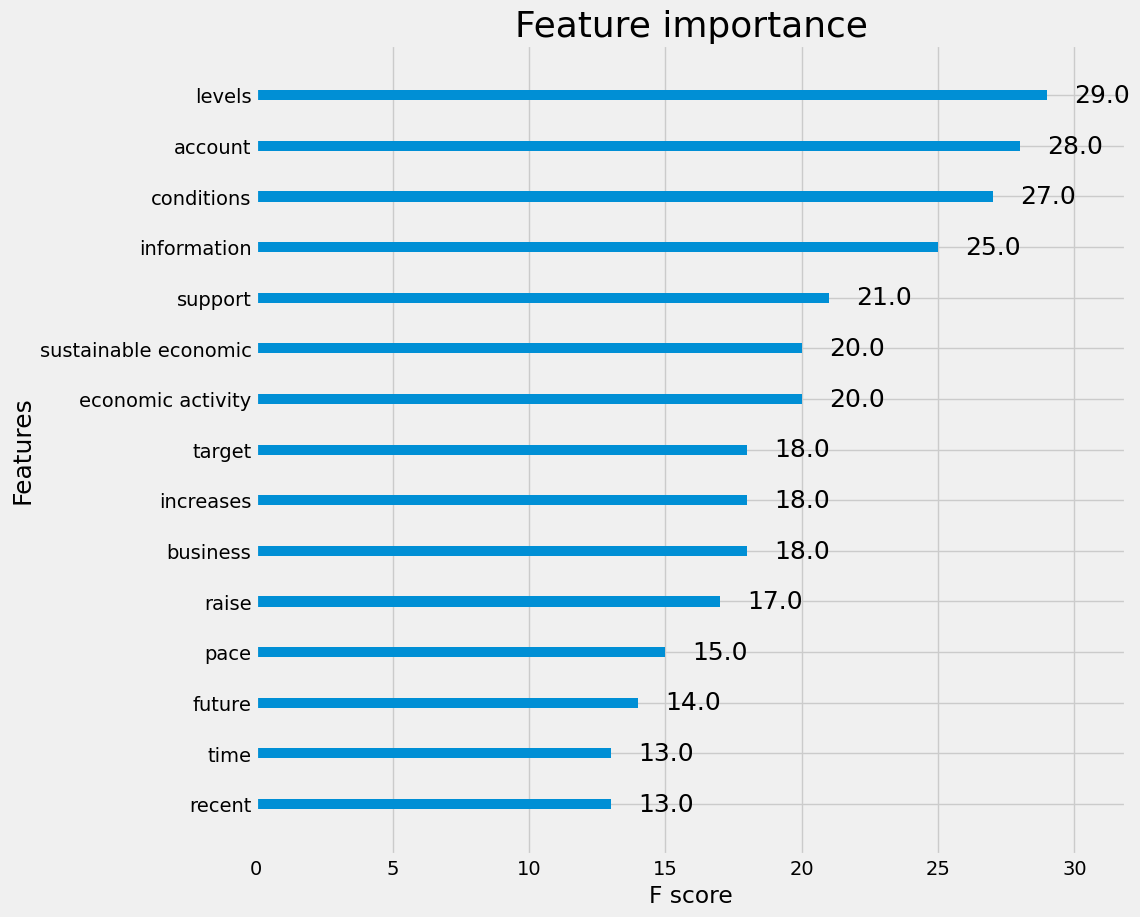

In [28]:
## Feature importance

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 18})
ax.yaxis.label.set_size(18)
plot_importance(xgb_model, max_num_features = 15, ax=ax);

## Ploting Actual VS Predicted
Plotting the predicted rate changes and actual rates changes together,it is clear that the model correctly predicted the most of data points.

In [29]:
## Defeine predictions vs actual

y_pred = y.copy()
y_pred['change_6_pred'] = xgb_model.predict(text_tfidf)
y_pred['change_6_pred'] = y_pred['change_6_pred'] -2.5
y_pred['change_6'] = y_pred['change_6']

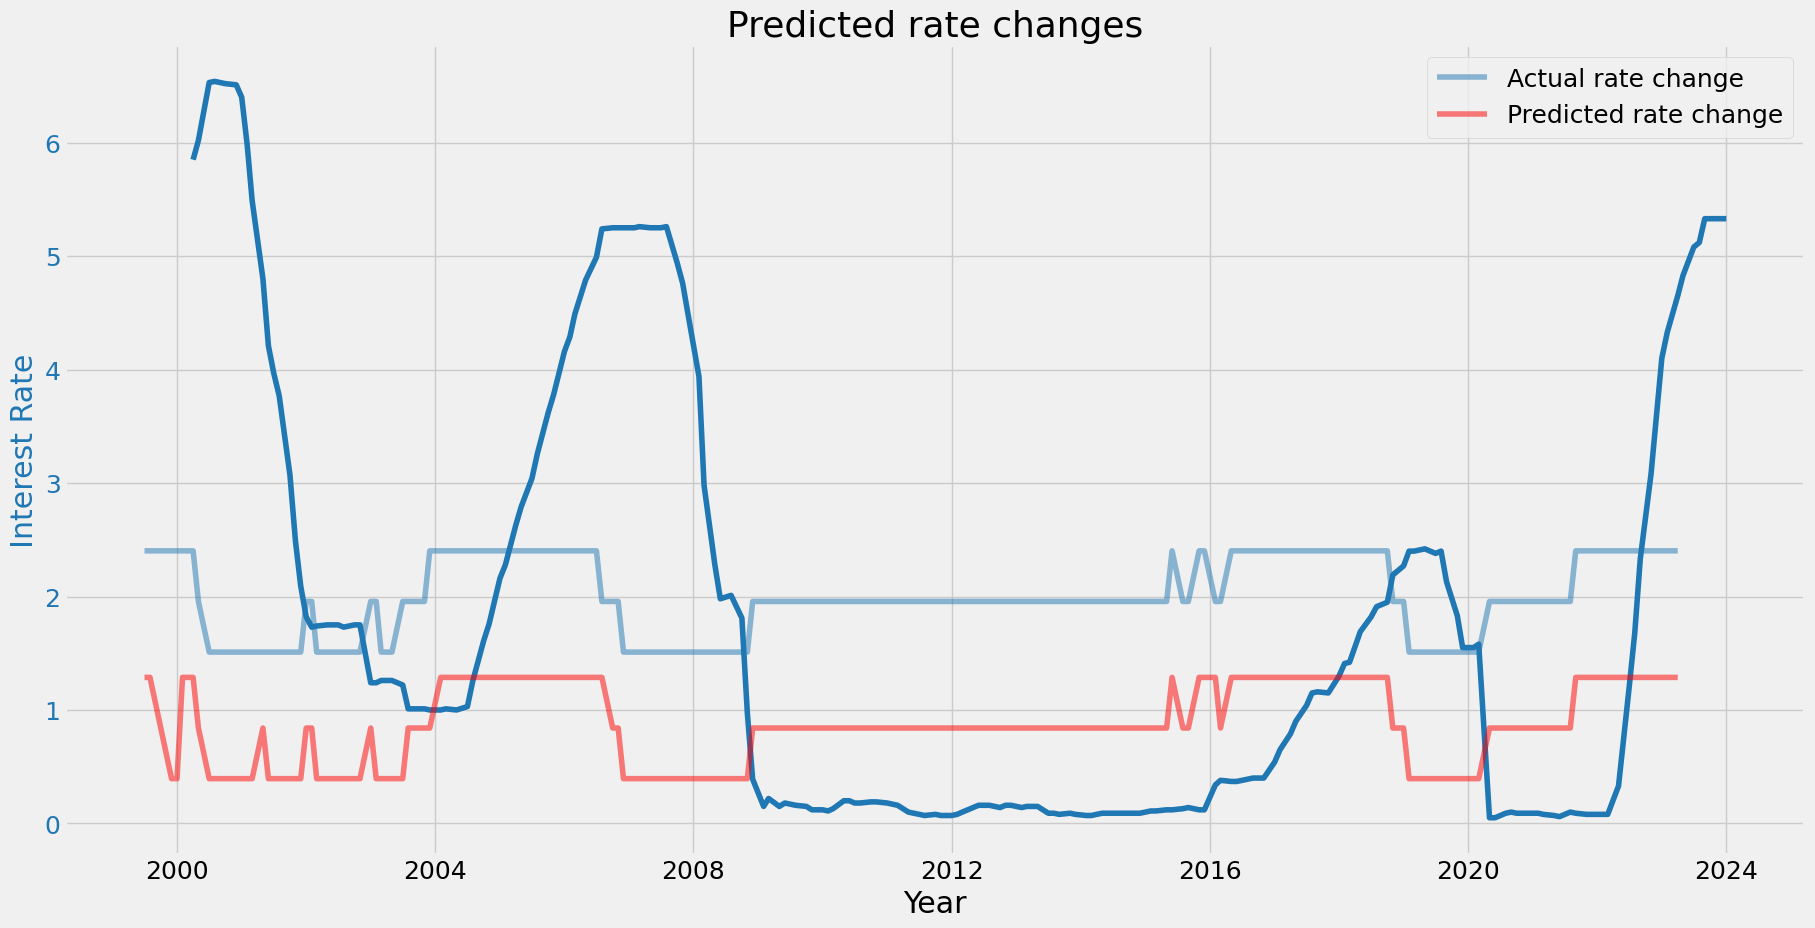

In [30]:
## Plot the interest rate, actual change, predicted change

fig, ax1 = plt.subplots(figsize=(20, 10))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Interest Rate', color=color)
ax1.plot(df_temp['rate'][6:], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
ax2.set_ylim(bottom=-4, top=12)
ax2.get_yaxis().set_visible(False)

color = 'tab:blue'
ax2.set_ylabel('Interest Rate Change', color=color)
ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label
         ='Actual rate change')
ax2.tick_params(axis='y', labelcolor=color)

color = 'red'
ax2.plot(y_pred['change_6_pred'], color=color, alpha=0.5, label='Predicted rate change')
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()
plt.title('Predicted rate changes')
plt.show()

## Partial Data Testing
By removing long periods of recent data, we can see how this affects the prediction accuracy of recent periods. When using only data before 2008 for training and data after 2008 for testing, we obtained the prediction score significantly lower than the previous one. It wasn't able to correctly identify the past unprecedented low and neutral interest rate environment after 2010.

In [31]:
## XGBoost model fitting and testing

def xgb_function(text_partial_train, y_partial_train, text_partial_test, y_partial_test):
    xgb_model = XGBClassifier(objective='multi:softmax',
                              max_depth=3,
                              num_classes=3)

    # Show performance scores for the partial set
    train_scores = []
    test_scores = []

    for x in range(5):
        X_train, X_test, y_train, y_test = train_test_split(text_partial_train, y_partial_train , test_size=0.3)

        xgb_model.fit(X_train, y_train)
        y_pred = xgb_model.predict(X_test)

        test_score = round(xgb_model.score(X_test, y_test),2)
        train_score = round(xgb_model.score(X_train, y_train),2)

        train_scores.append(train_score)
        test_scores.append(test_score)
    print(f'Train partial set average (pre-split): {np.mean(train_scores)}')
    print(f'Test partial set average (pre-split): {np.mean(test_scores)}')

    # Show performance scores for the full set
    full_score = round(xgb_model.score(text_partial_test, y_partial_test),2)
    print(f'Post-split date range score: {full_score}')

    # Plot predictions
    y_pred = y_partial_test.copy()
    y_pred['change_6_pred'] = xgb_model.predict(text_partial_test)
    y_pred['change_6_pred'] = y_pred['change_6_pred'] - 2.5
    y_pred['change_6'] = y_pred['change_6']

    fig, ax1 = plt.subplots(figsize=(20, 10))

    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Interest Rate', color=color)
    ax1.plot( df_temp['rate'][6:], color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()
    ax2.set_ylim(bottom=-4, top=12)
    ax2.get_yaxis().set_visible(False)

    color = 'tab:blue'
    ax2.set_ylabel('Interest Rate Change', color=color)
    ax2.plot(y_pred['change_6'], color=color, alpha=0.5, label='Actual rate change')
    ax2.tick_params(axis='y', labelcolor=color)

    color = 'red'
    ax2.plot(y_pred['change_6_pred'], color=color, alpha=0.5, label='Predicted rate change')
    ax2.tick_params(axis='y', labelcolor=color)

    plt.legend()
    plt.title('Predicted rate changes - Partial Dataset Training')
    plt.show()

    return None

In [32]:
## Split data based on date
y_partial_train = y.loc[:'2008-01-01']
text_partial_train = text_tfidf.loc[:y_partial_train.shape[0]-1]
y_partial_test = y.loc['2008-02-01':]
text_partial_test = text_tfidf.loc[:y_partial_test.shape[0]-1]

Train partial set average (pre-split): 1.0
Test partial set average (pre-split): 0.6819999999999999
Post-split date range score: 0.23


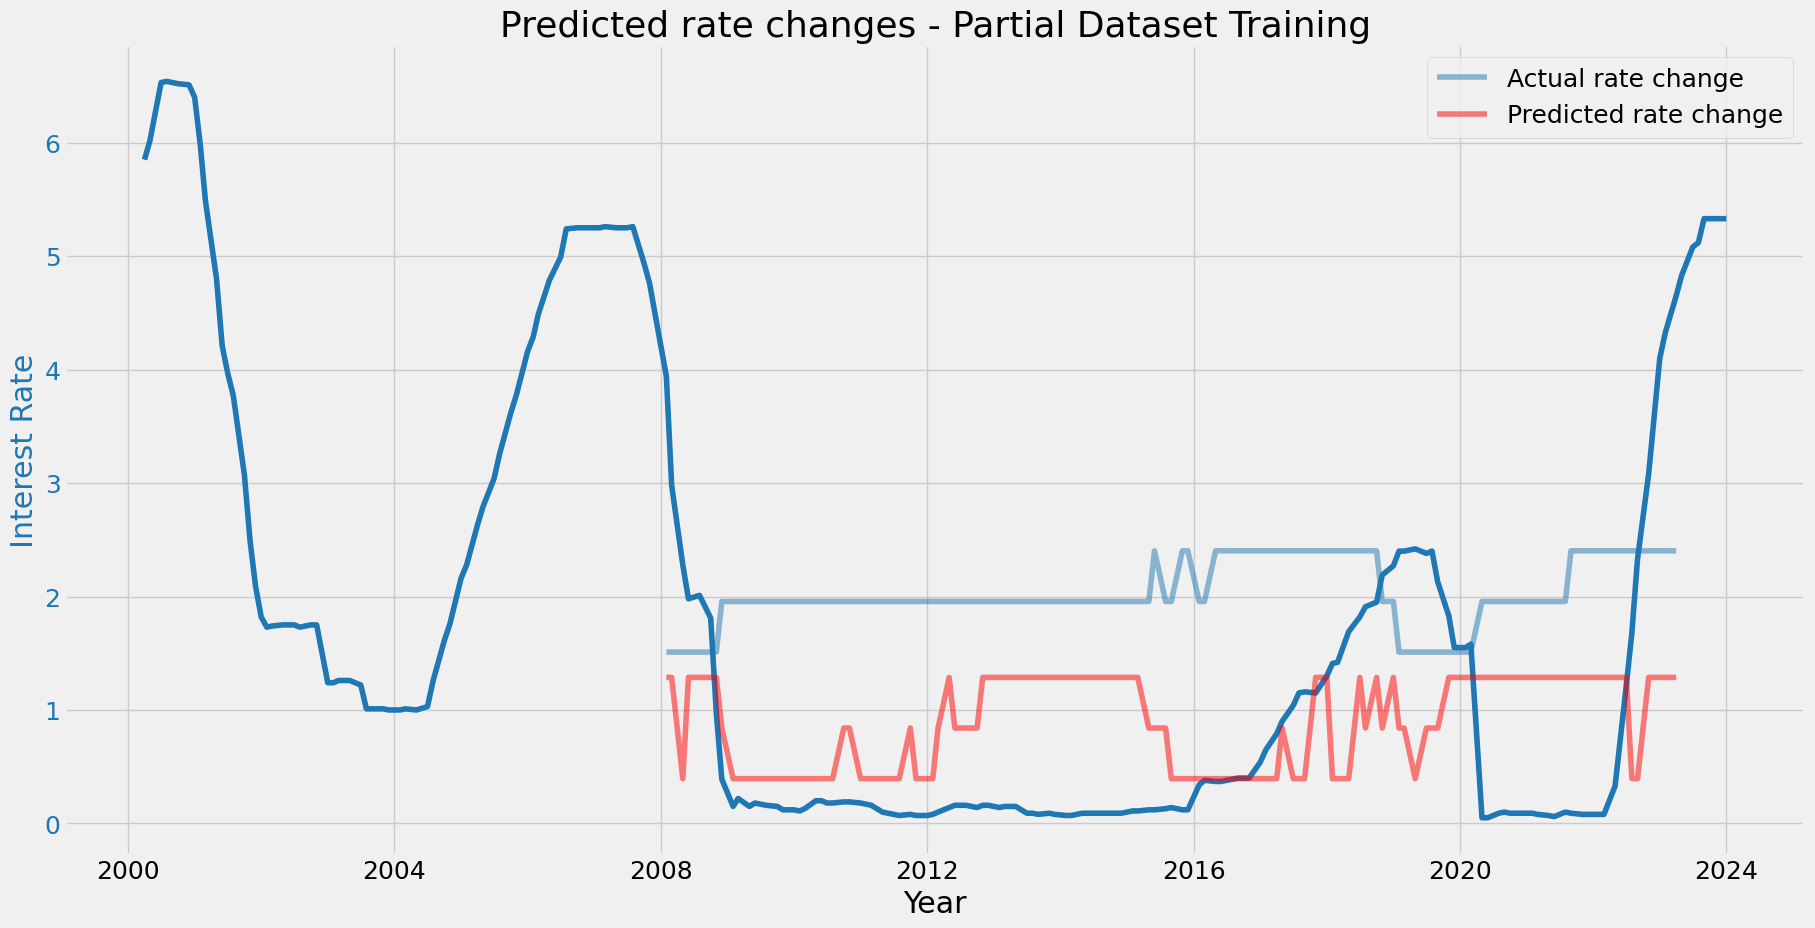

In [33]:
# xgb_function(text_partial, y_partial, text, y)
xgb_function(text_partial_train, y_partial_train, text_partial_test, y_partial_test)

## Backtesting on the whole dataset

In reality, the tool would be used to estimate a rolling prediction every month.  Accuracy of long-term projections wouldn't be used and wouldn't be practical.  One would also want to train the model on as much relevant data as possible.  As such, the best accuracy score would be scoring it only on how well it predicts the immediate future over time. Here, we calculated the prediction with data in January and in June. <br><br>
The final test will be testing a sample of predictions from a large range of time.


In [34]:
years = [i for i in range(2005,2023)]
test_results = []


for x in years:
    y_partial = y.loc[:str(x-1)+'-01-01']
    text_partial = text_tfidf.loc[:y_partial.shape[0]-1]

    # Train test split - don't train the model on all data, reduce overfit
    X_train, X_test, y_train, y_test = train_test_split(text_partial, y_partial)

    # Train model
    xgb_model.fit(X_train, y_train)

    # Make prediction for next period
    pred = xgb_model.predict(text_tfidf.loc[y_partial.shape[0]:y_partial.shape[0]])
    actual = y[:y_partial.shape[0]].tail(1).iloc[0,0]

    if pred == actual:
        test_results.append(1)
    else:
        test_results.append(0)

    y_partial = y.loc[:str(x-1)+'-06-30']
    text_partial = text_tfidf.loc[:y_partial.shape[0]-1]

    # Train test split - don't train the model on all data, reduce overfit
    X_train, X_test, y_train, y_test = train_test_split(text_partial, y_partial)

    # Train model
    xgb_model.fit(X_train, y_train)

    # Make prediction for next period
    pred = xgb_model.predict(text_tfidf.loc[y_partial.shape[0]:y_partial.shape[0]])
    actual = y[:y_partial.shape[0]].tail(1).iloc[0,0]

    if pred == actual:
        test_results.append(1)
    else:
        test_results.append(0)

In [35]:
correct = sum(num == 1 for num in test_results)
incorrect = sum(num == 0 for num in test_results)
score = (correct / (correct+incorrect))
print('Score from a sample range: ' + str(round(score,2)))

Score from a sample range: 0.81


# Conclusion
When the model is trained only on past environments, it performs very poorly, around 30% at best with a split at the year 2008.  This proves that it does rely on the unique features of every interest rate environment to forecast accurately.  Using a rolling sample, with each sample given the most recent information (-6 months maximum), the performance is back up to about 80%.

If the model is not trained on a specific environment's statements, the statements may hold features that are significantly different from the past, and a model not trained on the new environment may have no predictive value. A model trained on the new current environment may be overfitting to the environment so far, and have no ability to anticipate a change.

There is no easy solution to forecasting US interest rates. NLP on FOMC statements may be a valuable tool if combined with several other tools. It should only be considered one flag. Even if a current market environment is unique, FOMC statements may still contain feature similarities from other past market shocks that forecasted rate change (Fed over-confidence, fed warnings about risk, etc).